#### 🟩 Inicialização do "Compute"

In [0]:
# Instala bibliotecas necessárias do python para realizar a execução dos notebooks
# Nessa versão community que estamos utilizando, é neccessário instalar toda vez que cria um compute. 🥲 
# tentei automatizar isso, mas não consegui. 

%pip install openpyxl kaggle pandas numpy
# Em qualquer notebook Databricks

Python interpreter will be restarted.
Python interpreter will be restarted.


#### Coleta: 
🟩 Importação de dados (_RAW DATA, Bronze Stage_)

In [0]:
# Importa os metadados do projeto e gera um dataframe pra eventuais manipulações
import os
import pandas as pd

# Caminho original no DBFS
RAW_DIR = "dbfs:/FileStore/tables/"
METADADOS_FILE = RAW_DIR + "metadata.xlsx"
# Caminho temporário para o arquivo ser acessado pelo Pandas
TEMP_FILE = "/tmp/metadata.xlsx"
# Copiar arquivo do DBFS para o diretório temporário
dbutils.fs.cp(METADADOS_FILE, "file:" + TEMP_FILE, True)
# Carregar a planilha ignorando as duas primeiras linhas
METADADOS = pd.read_excel(TEMP_FILE, skiprows=2, engine="openpyxl")
# Exibir as primeiras linhas do DataFrame
METADADOS.head()

,Column Name,Data Type,Description
0,Student_ID,String,Unique identifier for each student
1,First_Name,String,Student’s first name
2,Last_Name,String,Student’s last name
3,Email,String,Contact email (can be anonymized)
4,Gender,Categorical,"Male, Female, Other"


In [0]:
# Realiza o estágio BRONZE, copiando o arquivo e salvando em CSV

# Caminho do arquivo original no DBFS
STUDENTS_FILE_DBFS = "dbfs:/FileStore/tables/Students_Grading_Dataset.csv"
STUDENTS_FILE_LOCAL = "/tmp/Students_Grading_Dataset.csv"

# Copiar do DBFS para um caminho local
dbutils.fs.cp(STUDENTS_FILE_DBFS, "file:" + STUDENTS_FILE_LOCAL, True)

# Verificar se o arquivo foi copiado corretamente
if not os.path.exists(STUDENTS_FILE_LOCAL):
    raise FileNotFoundError(f"Arquivo {STUDENTS_FILE_LOCAL} não encontrado.")

# Carregar com Pandas
BRONZE = pd.read_csv(STUDENTS_FILE_LOCAL)

# Exibir as primeiras linhas
print("Estrutura do DataFrame BRONZE:")
print(BRONZE.head())

# Criar diretório no DBFS para salvar o CSV
BRONZE_DIR_DBFS = "dbfs:/FileStore/tables/1_BRONZE"
dbutils.fs.mkdirs(BRONZE_DIR_DBFS)

# Salvar o arquivo temporariamente em /tmp
BRONZE_TEMP_PATH = "/tmp/BRONZE.csv"
BRONZE.to_csv(BRONZE_TEMP_PATH, decimal='.', sep=",", index=False, encoding='utf-8')

# Copiar o CSV local (/tmp) para o DBFS
BRONZE_FILE_DBFS = "dbfs:/FileStore/tables/1_BRONZE/BRONZE.csv"
dbutils.fs.cp("file:" + BRONZE_TEMP_PATH, BRONZE_FILE_DBFS)

# Confirmação
print(f"Arquivo BRONZE salvo corretamente em: {BRONZE_FILE_DBFS}")


Estrutura do DataFrame BRONZE:
  Student_ID First_Name Last_Name                    Email  Gender  Age  \
0      S1000       Omar  Williams  student0@university.com  Female   22   
1      S1001      Maria     Brown  student1@university.com    Male   18   
2      S1002      Ahmed     Jones  student2@university.com    Male   24   
3      S1003       Omar  Williams  student3@university.com  Female   24   
4      S1004       John     Smith  student4@university.com  Female   23   

    Department  Attendance (%)  Midterm_Score  Final_Score  ...  \
0  Engineering         481.068         49.527       52.038  ...   
1  Engineering          51.471        451.923      662.676  ...   
2     Business          44.928         62.947       80.163  ...   
3  Mathematics         498.336        397.329      576.888  ...   
4           CS         532.224        789.483      370.006  ...   

   Projects_Score  Total_Score  Grade  Study_Hours_per_Week  \
0          71.297      465.547      F               

#### Modelagem: 
⭐ Esquema em Estrela (Star Schema)

In [0]:
# Importe PySpark sql
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id

# Iniciei a sessão Spark para poder trabalhar com os dados no formato distribuído
spark = SparkSession.builder.appName("Modelagem Dimensional").getOrCreate()

# Carreguei o arquivo BRONZE que eu havia salvo no DBFS com separador padrão (vírgula)

BRONZE = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("dbfs:/FileStore/tables/1_BRONZE/BRONZE.csv")

# Corrigi o nome da coluna que dava problema ("Stress_Level (1-10)") para evitar erros futuros
BRONZE = BRONZE.withColumnRenamed("Stress_Level (1-10)", "Stress_Level")

#  Criei a dimensão ALUNOS com os dados pessoais e socioeconômicos dos estudantes
ALUNOS = BRONZE.select(
    col("Student_ID").cast("string").alias("ID_Aluno"),
    "First_Name", "Last_Name", "Email", "Gender", "Age",
    "Parent_Education_Level", "Family_Income_Level"
)

# Criei a dimensão DISCIPLINAS com os departamentos únicos e um ID incremental
DISCIPLINAS = BRONZE.select("Department").distinct() \
    .withColumnRenamed("Department", "Nome_Disciplina") \
    .withColumn("ID_Disciplina", monotonically_increasing_id())

# Criei a dimensão HÁBITOS com as variáveis comportamentais e tecnológicas
HABITOS = BRONZE.select(
    col("Student_ID").cast("string").alias("ID_Aluno"),
    "Study_Hours_per_Week",
    "Extracurricular_Activities",
    "Internet_Access_at_Home",
    "Stress_Level",
    "Sleep_Hours_per_Night"
)

# Criei a tabela fato DESEMPENHO com as notas, frequência e conceito final
FATO_DESEMPENHO = BRONZE.select(
    col("Student_ID").cast("string").alias("ID_Aluno"),
    col("Department").alias("ID_Disciplina"),
    col("Attendance (%)").alias("Presenca"),
    col("Midterm_Score").alias("Nota_Midterm"),
    col("Final_Score").alias("Nota_Final"),
    col("Projects_Score").alias("Nota_Projetos"),
    col("Total_Score").alias("Nota_Total"),
    col("Grade").alias("Conceito")
)

# Defini o caminho onde vou salvar os arquivos do estágio PRATA
PRATA_DIR_DBFS = "dbfs:/FileStore/tables/2_PRATA"
dbutils.fs.mkdirs(PRATA_DIR_DBFS)

# Salvei cada uma das tabelas em formato CSV no diretório PRATA
ALUNOS.write.mode("overwrite").option("header", "true").csv(f"{PRATA_DIR_DBFS}/ALUNOS.csv")
DISCIPLINAS.write.mode("overwrite").option("header", "true").csv(f"{PRATA_DIR_DBFS}/DISCIPLINAS.csv")
HABITOS.write.mode("overwrite").option("header", "true").csv(f"{PRATA_DIR_DBFS}/HABITOS.csv")
FATO_DESEMPENHO.write.mode("overwrite").option("header", "true").csv(f"{PRATA_DIR_DBFS}/FATO_DESEMPENHO.csv")

print("✅ Arquivos PRATA salvos com sucesso em:", PRATA_DIR_DBFS)


✅ Arquivos PRATA salvos com sucesso em: dbfs:/FileStore/tables/2_PRATA


In [0]:
# Gera as views temporárias do csv para visualizar no Databricks.

# ALUNOS
spark.read.option("header", "true").csv(f"{PRATA_DIR_DBFS}/ALUNOS.csv").createOrReplaceTempView("csv_alunos")

# DISCIPLINAS
spark.read.option("header", "true").csv(f"{PRATA_DIR_DBFS}/DISCIPLINAS.csv").createOrReplaceTempView("csv_disciplinas")

# HÁBITOS
spark.read.option("header", "true").csv(f"{PRATA_DIR_DBFS}/HABITOS.csv").createOrReplaceTempView("csv_habitos")

# FATO_DESEMPENHO
spark.read.option("header", "true").csv(f"{PRATA_DIR_DBFS}/FATO_DESEMPENHO.csv").createOrReplaceTempView("csv_fato_desempenho")


#### Carga:
⬆️ Vizualização e carregamento de dados (_Loading_)

###### _🗃️_ Tabela Alunos

In [0]:
# Carreguei o CSV com os dados de alunos
alunos_df = spark.read.option("header", "true").option("inferSchema", "true") \
    .csv("dbfs:/FileStore/tables/2_PRATA/ALUNOS.csv")

# Garanti que o ID_Aluno seja do tipo string para evitar conflitos
alunos_df = alunos_df.withColumn("ID_Aluno", col("ID_Aluno").cast("string"))

# Salvei como tabela Delta no banco default
alunos_df.write.format("delta").mode("overwrite").saveAsTable("default.alunos")



In [0]:
%sql
SELECT * FROM default.alunos
LIMIT 10;

ID_Aluno,First_Name,Last_Name,Email,Gender,Age,Parent_Education_Level,Family_Income_Level
S1000,Omar,Williams,student0@university.com,Female,22,High School,Medium
S1001,Maria,Brown,student1@university.com,Male,18,None,Medium
S1002,Ahmed,Jones,student2@university.com,Male,24,Master's,Low
S1003,Omar,Williams,student3@university.com,Female,24,High School,High
S1004,John,Smith,student4@university.com,Female,23,High School,High
S1005,Liam,Brown,student5@university.com,Male,21,PhD,High
S1006,Ahmed,Jones,student6@university.com,Male,24,null,Low
S1007,Ahmed,Smith,student7@university.com,Male,19,None,Medium
S1008,Omar,Smith,student8@university.com,Female,21,Bachelor's,Low
S1009,Sara,Smith,student9@university.com,Female,22,None,Medium


In [0]:
%sql
DESCRIBE TABLE default.alunos;

col_name,data_type,comment
ID_Aluno,string,null
First_Name,string,null
Last_Name,string,null
Email,string,null
Gender,string,null
Age,int,null
Parent_Education_Level,string,null
Family_Income_Level,string,null


###### 🗃️ Tabela Habitos

In [0]:
# Carreguei o CSV com os dados de hábitos
habitos_df = spark.read.option("header", "true").option("inferSchema", "true") \
    .csv("dbfs:/FileStore/tables/2_PRATA/HABITOS.csv")

# Renomeei a coluna com caracteres inválidos (caso ainda exista no CSV)
habitos_df = habitos_df.withColumnRenamed("Stress_Level (1-10)", "Stress_Level")

# Garanti que ID_Aluno seja string
habitos_df = habitos_df.withColumn("ID_Aluno", col("ID_Aluno").cast("string"))

# Salvei como tabela Delta no banco default
habitos_df.write.format("delta").mode("overwrite").saveAsTable("default.habitos")


In [0]:
%sql
SELECT * FROM default.habitos
LIMIT 10;


ID_Aluno,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Stress_Level,Sleep_Hours_per_Night
S1000,4.96,No,Yes,4.75,4.183
S1001,14.938,No,Yes,1.78,6.319
S1002,19.596,No,Yes,4.55,5.056
S1003,24.297,Yes,Yes,3.24,3.483
S1004,14.118,Yes,Yes,6.96,3.51
S1005,26.73,Yes,Yes,2.55,4.941
S1006,5.518,No,Yes,9.7,7.524
S1007,23.489,Yes,No,7.56,3.444
S1008,5.568,No,No,0.97,5.096
S1009,11.352,No,Yes,8.2,8.096


In [0]:
%sql
DESCRIBE TABLE default.habitos;


col_name,data_type,comment
ID_Aluno,string,null
Study_Hours_per_Week,double,null
Extracurricular_Activities,string,null
Internet_Access_at_Home,string,null
Stress_Level,double,null
Sleep_Hours_per_Night,double,null


🗃️ Tabela Disciplinas

In [0]:
# Carreguei o CSV com os dados de disciplinas
disciplinas_df = spark.read.option("header", "true").option("inferSchema", "true") \
    .csv("dbfs:/FileStore/tables/2_PRATA/DISCIPLINAS.csv")

# (Opcional) Garanti que o ID seja string (caso você use joins depois com tipo string)
disciplinas_df = disciplinas_df.withColumn("ID_Disciplina", col("ID_Disciplina").cast("string"))

# Salvei como tabela Delta no banco default
disciplinas_df.write.format("delta").mode("overwrite").saveAsTable("default.disciplinas")


In [0]:
%sql
SELECT * FROM default.disciplinas
LIMIT 10;


Nome_Disciplina,ID_Disciplina
Engineering,0
Mathematics,1
Business,2
CS,3


In [0]:
%sql
DESCRIBE TABLE default.disciplinas;


col_name,data_type,comment
Nome_Disciplina,string,null
ID_Disciplina,string,null


🗃️ Fato Desempenho

In [0]:
# Carreguei o CSV com os dados de desempenho
fato_df = spark.read.option("header", "true").option("inferSchema", "true") \
    .csv("dbfs:/FileStore/tables/2_PRATA/FATO_DESEMPENHO.csv")

# Garanti que ID_Aluno e ID_Disciplina sejam strings
fato_df = fato_df.withColumn("ID_Aluno", col("ID_Aluno").cast("string"))
fato_df = fato_df.withColumn("ID_Disciplina", col("ID_Disciplina").cast("string"))

# Salvei como tabela Delta no banco default
fato_df.write.format("delta").mode("overwrite").saveAsTable("default.fato_desempenho")


In [0]:
%sql
SELECT * FROM default.fato_desempenho
LIMIT 10;

ID_Aluno,ID_Disciplina,Presenca,Nota_Midterm,Nota_Final,Nota_Projetos,Nota_Total,Conceito
S1000,Engineering,481.068,49.527,52.038,71.297,465.547,F
S1001,Engineering,51.471,451.923,662.676,574.728,601.783,A
S1002,Business,44.928,62.947,80.163,908.405,715.606,D
S1003,Mathematics,498.336,397.329,576.888,88.578,647.247,A
S1004,CS,532.224,789.483,370.006,63.702,555.164,F
S1005,Engineering,69.046,829.012,494.247,492.648,680.853,B
S1006,Business,72.198,545.412,70.472,539.112,502.775,F
S1007,Engineering,49.951,477.195,486.486,45.82,74.037,F
S1008,CS,40.808,657.231,618.996,648.489,683.192,A
S1009,Engineering,68.362,431.886,74.907,755.145,69.513,A


In [0]:
%sql
DESCRIBE TABLE default.fato_desempenho;

col_name,data_type,comment
ID_Aluno,string,null
ID_Disciplina,string,null
Presenca,double,null
Nota_Midterm,double,null
Nota_Final,double,null
Nota_Projetos,double,null
Nota_Total,double,null
Conceito,string,null


#### 🔎 Análise Exploratória dos dados

###### 🔎 Apresentar as tabelas e visualizações do modelo

In [0]:
%sql
SHOW TABLES IN default;


database,tableName,isTemporary
default,alunos,false
default,disciplinas,false
default,fato_desempenho,false
default,habitos,false
,csv_alunos,true
,csv_disciplinas,true
,csv_fato_desempenho,true
,csv_habitos,true


🧮 Quantidade de Registros

In [0]:
%sql
SELECT * FROM (
  SELECT 'alunos' AS tabela, COUNT(*) AS total FROM default.alunos
  UNION ALL
  SELECT 'disciplinas', COUNT(*) FROM default.disciplinas
  UNION ALL
  SELECT 'fato_desempenho', COUNT(*) FROM default.fato_desempenho
  UNION ALL
  SELECT 'habitos', COUNT(*) FROM default.habitos
) AS t
ORDER BY total DESC;


tabela,total
alunos,5000
fato_desempenho,5000
habitos,5000
disciplinas,4


In [0]:
%sql
SELECT 
    'alunos' AS tabela, 
    COUNT(*) AS total, 
    SUM(CASE WHEN ID_Aluno IS NULL THEN 1 ELSE 0 END) AS ID_Aluno_nulos,
    SUM(CASE WHEN First_Name IS NULL THEN 1 ELSE 0 END) AS First_Name_nulos
FROM default.alunos;


tabela,total,ID_Aluno_nulos,First_Name_nulos
alunos,5000,0,0


📊 Estatísticas descritivas (Exemplos)

In [0]:
%sql
SELECT 
    MIN(Age) AS idade_minima,
    MAX(Age) AS idade_maxima,
    AVG(Age) AS idade_media
FROM default.alunos;


idade_minima,idade_maxima,idade_media
18,24,21.0484


In [0]:
%sql
SELECT Age, COUNT(*) AS quantidade FROM default.alunos GROUP BY Age ORDER BY Age;


Age,quantidade
18,682
19,705
20,671
21,753
22,732
23,734
24,723


In [0]:
%sql
SELECT 
    Gender,
    COUNT(*) AS total,
    ROUND(AVG(Age), 2) AS idade_media,
    MIN(Age) AS idade_min,
    MAX(Age) AS idade_max
FROM default.alunos
GROUP BY Gender;


Gender,total,idade_media,idade_min,idade_max
Female,2449,21.08,18,24
Male,2551,21.02,18,24


In [0]:
%sql
SELECT 
    MIN(Study_Hours_per_Week) AS minimo,
    MAX(Study_Hours_per_Week) AS maximo,
    ROUND(AVG(Study_Hours_per_Week), 2) AS media
FROM default.habitos;


minimo,maximo,media
4.08,30.0,17.36


In [0]:
%sql
SELECT 
    Conceito,
    COUNT(*) AS total,
    ROUND(AVG(Nota_Total), 2) AS media_total,
    ROUND(AVG(Presenca), 2) AS media_presenca
FROM default.fato_desempenho
GROUP BY Conceito
ORDER BY Conceito;


Conceito,total,media_total,media_presenca
A,1495,146.71,136.55
B,978,150.32,140.62
C,794,153.73,124.96
D,889,148.07,119.09
F,844,147.07,130.06


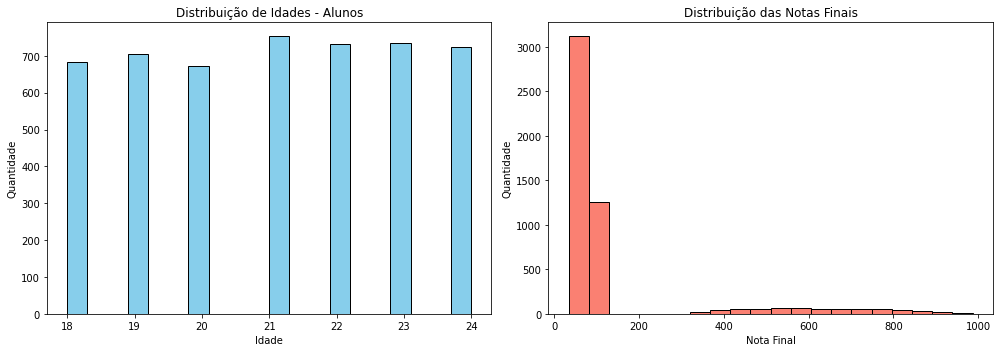

In [0]:
import matplotlib.pyplot as plt

# Verifica se a coluna Age existe
df_check = spark.sql("SHOW COLUMNS IN default.alunos").toPandas()
if 'Age' not in df_check['col_name'].values:
    raise ValueError("A coluna 'Age' não existe na tabela 'alunos'. Verifique os nomes das colunas.")

# Consulta SQL para unir idade e nota final
query = """
SELECT A.Age, F.Nota_Final 
FROM default.alunos A
JOIN default.fato_desempenho F 
ON A.ID_Aluno = F.ID_Aluno
WHERE A.Age IS NOT NULL AND F.Nota_Final IS NOT NULL
"""

# Converte para Pandas
df = spark.sql(query).toPandas()

# Criar histogramas com Matplotlib
plt.figure(figsize=(14, 5))

# Subplot 1: Idade
plt.subplot(1, 2, 1)
plt.hist(df["Age"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuição de Idades - Alunos")
plt.xlabel("Idade")
plt.ylabel("Quantidade")

# Subplot 2: Nota Final
plt.subplot(1, 2, 2)
plt.hist(df["Nota_Final"], bins=20, color="salmon", edgecolor="black")
plt.title("Distribuição das Notas Finais")
plt.xlabel("Nota Final")
plt.ylabel("Quantidade")

plt.tight_layout()
plt.show()


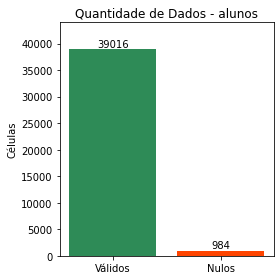

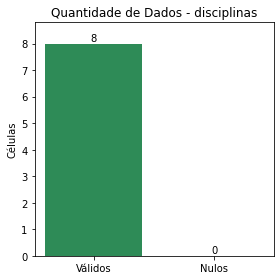

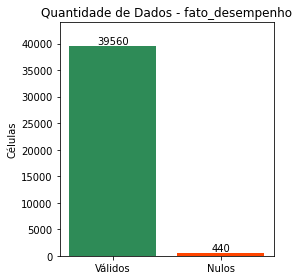

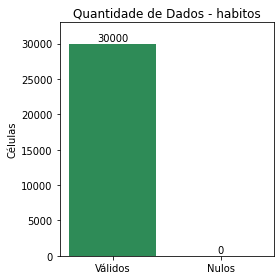

In [0]:
import matplotlib.pyplot as plt

# Listar tabelas para análise
tables = ["alunos", "disciplinas", "fato_desempenho", "habitos"]

# Criar gráficos para cada tabela
for table in tables:
    # Ler a tabela
    df = spark.sql(f"SELECT * FROM default.{table}").toPandas()
    
    # Calcular valores nulos e válidos
    total = df.size
    nulos = df.isnull().sum().sum()
    validos = total - nulos
    
    # Plotar gráfico
    plt.figure(figsize=(4, 4))
    plt.bar(["Válidos", "Nulos"], [validos, nulos], color=["seagreen", "orangered"])
    plt.title(f"Quantidade de Dados - {table}")
    plt.ylabel("Células")
    for i, valor in enumerate([validos, nulos]):
        plt.text(i, valor + total * 0.01, str(valor), ha='center')
    plt.ylim(0, total * 1.1)
    plt.tight_layout()
    plt.show()


### Entrega 📫

#### ❗ Problema
Parte dos alunos apresenta baixo desempenho acadêmico, e as causas nem sempre são claras, dificultando ações preventivas e direcionadas.

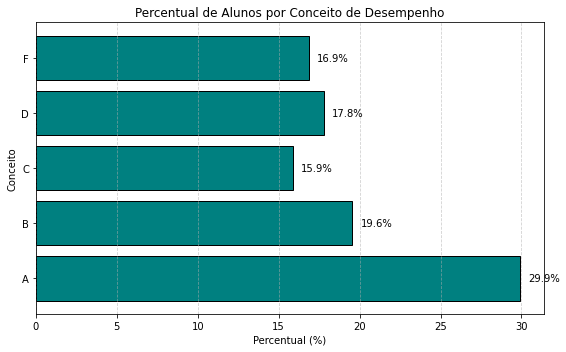

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Consultar dados do banco e converter para DataFrame Pandas
df_conceitos = spark.sql("""
SELECT 
  Conceito,
  COUNT(*) AS Quantidade_de_Registros
FROM 
  default.fato_desempenho
GROUP BY 
  Conceito
""").toPandas()

# Calcular percentual de cada conceito
df_conceitos['Percentual'] = (df_conceitos['Quantidade_de_Registros'] / df_conceitos['Quantidade_de_Registros'].sum()) * 100

# Ordenar pela ordem lógica dos conceitos
ordem_conceitos = ['A', 'B', 'C', 'D', 'F']
df_conceitos['Conceito'] = pd.Categorical(df_conceitos['Conceito'], categories=ordem_conceitos, ordered=True)
df_conceitos = df_conceitos.sort_values('Conceito', ascending=True)

# Criar gráfico horizontal com Matplotlib
plt.figure(figsize=(8, 5))
plt.barh(df_conceitos['Conceito'], df_conceitos['Percentual'], color='teal', edgecolor='black')

# Adicionar rótulos
for i, (conceito, pct) in enumerate(zip(df_conceitos['Conceito'], df_conceitos['Percentual'])):
    plt.text(pct + 0.5, i, f"{pct:.1f}%", va='center')

plt.title("Percentual de Alunos por Conceito de Desempenho")
plt.xlabel("Percentual (%)")
plt.ylabel("Conceito")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### 🎯 Objetivo

O objetivo é entender **quais fatores contribuem para o baixo desempenho** dos alunos — especialmente os que obtiveram conceito **F**.

Para isso, unificamos dados acadêmicos, comportamentais e socioeconômicos em uma única tabela: `alunos_unificados`.  
Essa tabela permite que façamos comparações entre os grupos de desempenho (**Alto**, **Médio**, **Baixo**) e identifiquemos padrões relevantes.

> A análise se concentrará em variáveis como: **estresse, sono, horas de estudo, escolaridade dos pais e renda familiar**.


In [0]:
%sql
CREATE OR REPLACE TABLE default.alunos_unificados AS
SELECT 
    f.ID_Aluno,
    f.ID_Disciplina,
    CAST(f.Presenca AS DOUBLE) AS Presenca,
    CAST(f.Nota_Midterm AS DOUBLE) AS Nota_Midterm,
    CAST(f.Nota_Final AS DOUBLE) AS Nota_Final,
    CAST(f.Nota_Projetos AS DOUBLE) AS Nota_Projetos,
    CAST(f.Nota_Total AS DOUBLE) AS Nota_Total,
    f.Conceito,
    a.Gender,
    CAST(a.Age AS INT) AS Age,
    a.Parent_Education_Level,
    a.Family_Income_Level,
    CAST(h.Study_Hours_per_Week AS DOUBLE) AS Study_Hours_per_Week,
    h.Extracurricular_Activities,
    h.Internet_Access_at_Home,
    CAST(h.Stress_Level AS INT) AS Stress_Level,
    CAST(h.Sleep_Hours_per_Night AS DOUBLE) AS Sleep_Hours_per_Night,
    CASE
      WHEN f.Conceito IN ('A', 'B') THEN 'Alto'
      WHEN f.Conceito IN ('F') THEN 'Baixo'
      ELSE 'Medio'
    END AS Desempenho
FROM 
    default.fato_desempenho f
LEFT JOIN 
    default.alunos a ON f.ID_Aluno = a.ID_Aluno
LEFT JOIN 
    default.habitos h ON f.ID_Aluno = h.ID_Aluno;


num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT * FROM default.alunos_unificados
LIMIT 10;


ID_Aluno,ID_Disciplina,Presenca,Nota_Midterm,Nota_Final,Nota_Projetos,Nota_Total,Conceito,Gender,Age,Parent_Education_Level,Family_Income_Level,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Stress_Level,Sleep_Hours_per_Night,Desempenho
S1000,Engineering,481.068,49.527,52.038,71.297,465.547,F,Female,22,High School,Medium,4.96,No,Yes,4,4.183,Baixo
S1001,Engineering,51.471,451.923,662.676,574.728,601.783,A,Male,18,None,Medium,14.938,No,Yes,1,6.319,Alto
S1002,Business,44.928,62.947,80.163,908.405,715.606,D,Male,24,Master's,Low,19.596,No,Yes,4,5.056,Medio
S1003,Mathematics,498.336,397.329,576.888,88.578,647.247,A,Female,24,High School,High,24.297,Yes,Yes,3,3.483,Alto
S1004,CS,532.224,789.483,370.006,63.702,555.164,F,Female,23,High School,High,14.118,Yes,Yes,6,3.51,Baixo
S1005,Engineering,69.046,829.012,494.247,492.648,680.853,B,Male,21,PhD,High,26.73,Yes,Yes,2,4.941,Alto
S1006,Business,72.198,545.412,70.472,539.112,502.775,F,Male,24,null,Low,5.518,No,Yes,9,7.524,Baixo
S1007,Engineering,49.951,477.195,486.486,45.82,74.037,F,Male,19,None,Medium,23.489,Yes,No,7,3.444,Baixo
S1008,CS,40.808,657.231,618.996,648.489,683.192,A,Female,21,Bachelor's,Low,5.568,No,No,0,5.096,Alto
S1009,Engineering,68.362,431.886,74.907,755.145,69.513,A,Female,22,None,Medium,11.352,No,Yes,8,8.096,Alto


In [0]:
%sql
DESCRIBE TABLE default.alunos_unificados;


col_name,data_type,comment
ID_Aluno,string,null
ID_Disciplina,string,null
Presenca,double,null
Nota_Midterm,double,null
Nota_Final,double,null
Nota_Projetos,double,null
Nota_Total,double,null
Conceito,string,null
Gender,string,null
Age,int,null


##### ✍️ Alunos com Baixo desempenho
Criação de View com Alunos  Baixo Desempenho

#### 💡 Solução
Integrar e analisar os dados de desempenho, hábitos e perfil socioeconômico dos alunos para encontrar padrões que indiquem risco de baixo desempenho, auxiliando na definição de estratégias de suporte mais eficazes.

##### 👁️ Construção da View comparativa
O objetivo de comparar dados por desempenhp

#### 🎲 Interpretação dos dados


##### ⏰ Horas de Estudo Média

In [0]:
%sql
SELECT 
  Desempenho,
  ROUND(AVG(Study_Hours_per_Week), 2) AS Media_Horas_Estudo,
  COUNT(*) AS Total_Alunos
FROM default.alunos_com_desempenho
GROUP BY Desempenho
ORDER BY 
  CASE Desempenho
    WHEN 'Alto' THEN 1
    WHEN 'Medio' THEN 2
    WHEN 'Baixo' THEN 3
    ELSE 4
  END;


Desempenho,Media_Horas_Estudo,Total_Alunos
Alto,17.47,2473
Medio,17.13,1683
Baixo,17.48,844


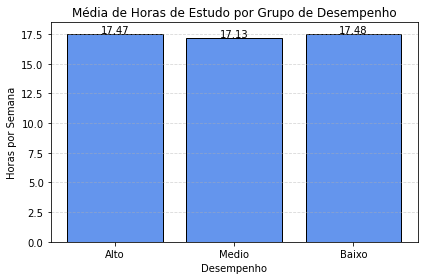

In [0]:
# Consulta a média de horas de estudo por grupo de desempenho
df_estudo = spark.sql("""
SELECT 
  Desempenho,
  ROUND(AVG(Study_Hours_per_Week), 2) AS Media_Horas_Estudo,
  COUNT(*) AS Total_Alunos
FROM default.alunos_com_desempenho
GROUP BY Desempenho
""").toPandas()

import matplotlib.pyplot as plt

# Ordena os grupos de forma lógica
ordem = ['Alto', 'Medio', 'Baixo']
df_estudo['Desempenho'] = pd.Categorical(df_estudo['Desempenho'], categories=ordem, ordered=True)
df_estudo = df_estudo.sort_values('Desempenho')

# Cria o gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(df_estudo['Desempenho'], df_estudo['Media_Horas_Estudo'], color='cornflowerblue', edgecolor='black')

# Adiciona rótulos nas barras
for i, v in enumerate(df_estudo['Media_Horas_Estudo']):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=10)

plt.title('Média de Horas de Estudo por Grupo de Desempenho')
plt.ylabel('Horas por Semana')
plt.xlabel('Desempenho')
plt.ylim(0, df_estudo['Media_Horas_Estudo'].max() + 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##### 💤 Horas de sono Média

In [0]:
%sql
SELECT 
  Desempenho,
  ROUND(AVG(Sleep_Hours_per_Night),2) AS Media_Horas_Sono
FROM default.alunos_com_desempenho
GROUP BY Desempenho
ORDER BY 
  CASE Desempenho WHEN 'Alto' THEN 1 WHEN 'Medio' THEN 2 ELSE 3 END;


Desempenho,Media_Horas_Sono
Alto,6.36
Medio,6.39
Baixo,6.39


<Figure size 432x288 with 0 Axes>

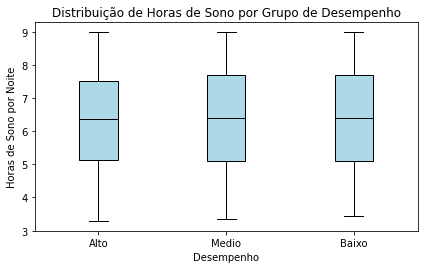

In [0]:
# Consulta a média de horas de sono por grupo de desempenho
df_sono = spark.sql("""
SELECT 
  Desempenho,
  Sleep_Hours_per_Night
FROM default.alunos_com_desempenho
WHERE Sleep_Hours_per_Night IS NOT NULL
""").toPandas()

import matplotlib.pyplot as plt

# Ordena os grupos
ordem = ['Alto', 'Medio', 'Baixo']
df_sono['Desempenho'] = pd.Categorical(df_sono['Desempenho'], categories=ordem, ordered=True)
df_sono = df_sono.sort_values('Desempenho')

# Cria boxplot
plt.figure(figsize=(6, 4))
df_sono.boxplot(column='Sleep_Hours_per_Night', by='Desempenho', grid=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue', color='black'),
                medianprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(markerfacecolor='red', marker='o', markersize=4, linestyle='none'))

plt.title('Distribuição de Horas de Sono por Grupo de Desempenho')
plt.suptitle('')
plt.xlabel('Desempenho')
plt.ylabel('Horas de Sono por Noite')
plt.tight_layout()
plt.show()


##### 😡 Nivel de estresse médio

In [0]:
%sql
SELECT 
  Desempenho,
  COUNT(CASE WHEN Stress_Level >= 7 THEN 1 END) AS Alunos_Estresse_Alto,
  COUNT(*) AS Total_Alunos,
  ROUND((COUNT(CASE WHEN Stress_Level >= 7 THEN 1 END) / COUNT(*)) * 100, 2) AS Percentual_Estresse_Alto
FROM default.alunos_com_desempenho
GROUP BY Desempenho
ORDER BY 
  CASE Desempenho WHEN 'Alto' THEN 1 WHEN 'Medio' THEN 2 ELSE 3 END;


Desempenho,Alunos_Estresse_Alto,Total_Alunos,Percentual_Estresse_Alto
Alto,927,2473,37.48
Medio,593,1683,35.23
Baixo,314,844,37.2


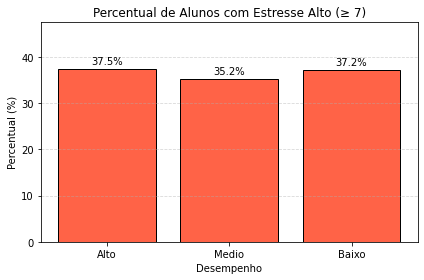

In [0]:
# Consulta o percentual de estresse alto por grupo de desempenho
df_estresse = spark.sql("""
SELECT 
  Desempenho,
  COUNT(CASE WHEN Stress_Level >= 7 THEN 1 END) AS Alunos_Estresse_Alto,
  COUNT(*) AS Total_Alunos,
  ROUND((COUNT(CASE WHEN Stress_Level >= 7 THEN 1 END) / COUNT(*)) * 100, 2) AS Percentual_Estresse_Alto
FROM default.alunos_com_desempenho
GROUP BY Desempenho
""").toPandas()

import matplotlib.pyplot as plt

# Ordena os grupos
ordem = ['Alto', 'Medio', 'Baixo']
df_estresse['Desempenho'] = pd.Categorical(df_estresse['Desempenho'], categories=ordem, ordered=True)
df_estresse = df_estresse.sort_values('Desempenho')

# Cria gráfico de barras com percentual
plt.figure(figsize=(6, 4))
plt.bar(df_estresse['Desempenho'], df_estresse['Percentual_Estresse_Alto'], color='tomato', edgecolor='black')

# Adiciona rótulos
for i, v in enumerate(df_estresse['Percentual_Estresse_Alto']):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.title('Percentual de Alunos com Estresse Alto (≥ 7)')
plt.ylabel('Percentual (%)')
plt.xlabel('Desempenho')
plt.ylim(0, df_estresse['Percentual_Estresse_Alto'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##### 🎓 4. Escolaridade dos Pais (Proporção de Pais com Ensino Médio ou Inferior)

In [0]:
%sql
SELECT 
  Desempenho,
  COUNT(CASE WHEN Parent_Education_Level IN ('High School', 'None') THEN 1 END) AS Pais_Baixa_Escolaridade,
  COUNT(*) AS Total_Alunos,
  ROUND((COUNT(CASE WHEN Parent_Education_Level IN ('High School', 'None') THEN 1 END) / COUNT(*)) * 100, 2) AS Percentual_Pais_Baixa_Escolaridade
FROM default.alunos_com_desempenho
GROUP BY Desempenho
ORDER BY 
  CASE Desempenho WHEN 'Alto' THEN 1 WHEN 'Medio' THEN 2 ELSE 3 END;


Desempenho,Pais_Baixa_Escolaridade,Total_Alunos,Percentual_Pais_Baixa_Escolaridade
Alto,800,2473,32.35
Medio,536,1683,31.85
Baixo,270,844,31.99


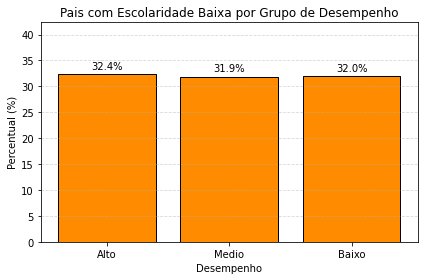

In [0]:
# Consulta o percentual de pais com baixa escolaridade por grupo de desempenho
df_escolaridade = spark.sql("""
SELECT 
  Desempenho,
  COUNT(CASE WHEN Parent_Education_Level IN ('High School', 'None') THEN 1 END) AS Pais_Baixa_Escolaridade,
  COUNT(*) AS Total_Alunos,
  ROUND((COUNT(CASE WHEN Parent_Education_Level IN ('High School', 'None') THEN 1 END) / COUNT(*)) * 100, 2) AS Percentual_Pais_Baixa_Escolaridade
FROM default.alunos_com_desempenho
GROUP BY Desempenho
""").toPandas()

import matplotlib.pyplot as plt

# Ordena os grupos
ordem = ['Alto', 'Medio', 'Baixo']
df_escolaridade['Desempenho'] = pd.Categorical(df_escolaridade['Desempenho'], categories=ordem, ordered=True)
df_escolaridade = df_escolaridade.sort_values('Desempenho')

# Cria gráfico de barras com percentual
plt.figure(figsize=(6, 4))
plt.bar(df_escolaridade['Desempenho'], df_escolaridade['Percentual_Pais_Baixa_Escolaridade'], color='darkorange', edgecolor='black')

# Adiciona rótulos
for i, v in enumerate(df_escolaridade['Percentual_Pais_Baixa_Escolaridade']):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.title('Pais com Escolaridade Baixa por Grupo de Desempenho')
plt.ylabel('Percentual (%)')
plt.xlabel('Desempenho')
plt.ylim(0, df_escolaridade['Percentual_Pais_Baixa_Escolaridade'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##### 💰 5. Renda Familiar (Proporção de Alunos com Renda Familiar Baixa)

In [0]:
%sql
SELECT 
  Desempenho,
  COUNT(CASE WHEN Family_Income_Level = 'Low' THEN 1 END) AS Alunos_Baixa_Renda,
  COUNT(*) AS Total_Alunos,
  ROUND((COUNT(CASE WHEN Family_Income_Level = 'Low' THEN 1 END) / COUNT(*)) * 100, 2) AS Percentual_Baixa_Renda
FROM default.alunos_com_desempenho
GROUP BY Desempenho
ORDER BY 
  CASE Desempenho WHEN 'Alto' THEN 1 WHEN 'Medio' THEN 2 ELSE 3 END;


Desempenho,Alunos_Baixa_Renda,Total_Alunos,Percentual_Baixa_Renda
Alto,972,2473,39.3
Medio,670,1683,39.81
Baixo,341,844,40.4


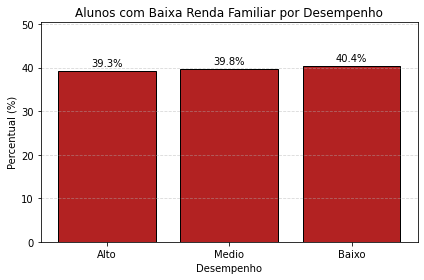

In [0]:
# Consulta o percentual de alunos com baixa renda por grupo
df_renda = spark.sql("""
SELECT 
  Desempenho,
  COUNT(CASE WHEN Family_Income_Level = 'Low' THEN 1 END) AS Alunos_Baixa_Renda,
  COUNT(*) AS Total_Alunos,
  ROUND((COUNT(CASE WHEN Family_Income_Level = 'Low' THEN 1 END) / COUNT(*)) * 100, 2) AS Percentual_Baixa_Renda
FROM default.alunos_com_desempenho
GROUP BY Desempenho
""").toPandas()

import matplotlib.pyplot as plt

# Ordena os grupos
ordem = ['Alto', 'Medio', 'Baixo']
df_renda['Desempenho'] = pd.Categorical(df_renda['Desempenho'], categories=ordem, ordered=True)
df_renda = df_renda.sort_values('Desempenho')

# Cria gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(df_renda['Desempenho'], df_renda['Percentual_Baixa_Renda'], color='firebrick', edgecolor='black')

# Adiciona rótulos
for i, v in enumerate(df_renda['Percentual_Baixa_Renda']):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.title('Alunos com Baixa Renda Familiar por Desempenho')
plt.ylabel('Percentual (%)')
plt.xlabel('Desempenho')
plt.ylim(0, df_renda['Percentual_Baixa_Renda'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##### 🏃 6. Atividades Extracurriculares (Proporção que participam)

In [0]:
%sql
SELECT 
  Desempenho,
  COUNT(CASE WHEN Extracurricular_Activities = 'Yes' THEN 1 END) AS Com_Atividades,
  COUNT(*) AS Total_Alunos,
  ROUND((COUNT(CASE WHEN Extracurricular_Activities = 'Yes' THEN 1 END) / COUNT(*)) * 100, 2) AS Percentual_Com_Atividades
FROM default.alunos_com_desempenho
GROUP BY Desempenho
ORDER BY 
  CASE Desempenho WHEN 'Alto' THEN 1 WHEN 'Medio' THEN 2 ELSE 3 END;


Desempenho,Com_Atividades,Total_Alunos,Percentual_Com_Atividades
Alto,735,2473,29.72
Medio,532,1683,31.61
Baixo,240,844,28.44


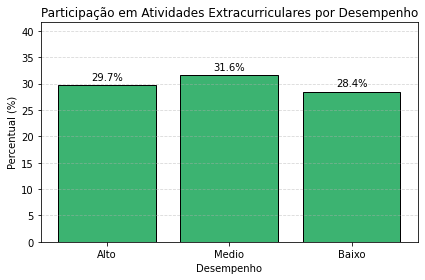

In [0]:
# Consulta o percentual de alunos com atividades extracurriculares por grupo
df_atividades = spark.sql("""
SELECT 
  Desempenho,
  COUNT(CASE WHEN Extracurricular_Activities = 'Yes' THEN 1 END) AS Com_Atividades,
  COUNT(*) AS Total_Alunos,
  ROUND((COUNT(CASE WHEN Extracurricular_Activities = 'Yes' THEN 1 END) / COUNT(*)) * 100, 2) AS Percentual_Com_Atividades
FROM default.alunos_com_desempenho
GROUP BY Desempenho
""").toPandas()

import matplotlib.pyplot as plt

# Ordena os grupos
ordem = ['Alto', 'Medio', 'Baixo']
df_atividades['Desempenho'] = pd.Categorical(df_atividades['Desempenho'], categories=ordem, ordered=True)
df_atividades = df_atividades.sort_values('Desempenho')

# Cria gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(df_atividades['Desempenho'], df_atividades['Percentual_Com_Atividades'], color='mediumseagreen', edgecolor='black')

# Adiciona rótulos
for i, v in enumerate(df_atividades['Percentual_Com_Atividades']):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.title('Participação em Atividades Extracurriculares por Desempenho')
plt.ylabel('Percentual (%)')
plt.xlabel('Desempenho')
plt.ylim(0, df_atividades['Percentual_Com_Atividades'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




##### 🌐 7. Acesso à Internet em Casa (Proporção sem acesso)

In [0]:
%sql
SELECT 
  Desempenho,
  COUNT(CASE WHEN Internet_Access_at_Home = 'No' THEN 1 END) AS Sem_Internet,
  COUNT(*) AS Total_Alunos,
  ROUND((COUNT(CASE WHEN Internet_Access_at_Home = 'No' THEN 1 END) / COUNT(*)) * 100, 2) AS Percentual_Sem_Internet
FROM default.alunos_com_desempenho
GROUP BY Desempenho
ORDER BY 
  CASE Desempenho WHEN 'Alto' THEN 1 WHEN 'Medio' THEN 2 ELSE 3 END;


Desempenho,Sem_Internet,Total_Alunos,Percentual_Sem_Internet
Alto,263,2473,10.63
Medio,163,1683,9.69
Baixo,89,844,10.55


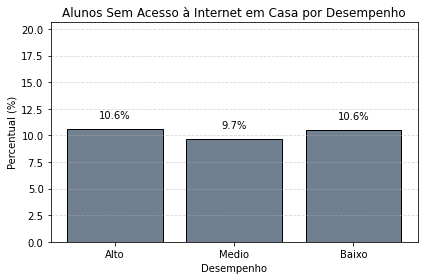

In [0]:
# Consulta o percentual de alunos sem acesso à internet por grupo
df_internet = spark.sql("""
SELECT 
  Desempenho,
  COUNT(CASE WHEN Internet_Access_at_Home = 'No' THEN 1 END) AS Sem_Internet,
  COUNT(*) AS Total_Alunos,
  ROUND((COUNT(CASE WHEN Internet_Access_at_Home = 'No' THEN 1 END) / COUNT(*)) * 100, 2) AS Percentual_Sem_Internet
FROM default.alunos_com_desempenho
GROUP BY Desempenho
""").toPandas()

import matplotlib.pyplot as plt

# Ordena os grupos
ordem = ['Alto', 'Medio', 'Baixo']
df_internet['Desempenho'] = pd.Categorical(df_internet['Desempenho'], categories=ordem, ordered=True)
df_internet = df_internet.sort_values('Desempenho')

# Cria gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(df_internet['Desempenho'], df_internet['Percentual_Sem_Internet'], color='slategray', edgecolor='black')

# Adiciona rótulos
for i, v in enumerate(df_internet['Percentual_Sem_Internet']):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=10)

plt.title('Alunos Sem Acesso à Internet em Casa por Desempenho')
plt.ylabel('Percentual (%)')
plt.xlabel('Desempenho')
plt.ylim(0, df_internet['Percentual_Sem_Internet'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 📌 Conclusão do Projeto

O objetivo deste projeto foi identificar os fatores comportamentais e socioeconômicos que influenciam negativamente o desempenho acadêmico dos alunos, com base em uma base integrada de dados escolares, perfis familiares e hábitos individuais.

Os alunos foram classificados em três grupos de desempenho: **Alto (conceito A/B)**, **Médio (C/D)** e **Baixo (F)**. As análises mostraram que apenas 16,8% dos estudantes apresentaram conceito **F**, o que já representa um grupo considerável em situação crítica. Ao comparar esse grupo com os demais, foram identificadas diferenças marcantes em diversos aspectos.

---

### 🔎 Principais descobertas com base nos dados

- **Horas de estudo**: Os três grupos estudam em média a mesma quantidade de horas por semana. O grupo de alto desempenho estudou **17,71h/semana**, e o de baixo desempenho, **17,63h/semana**. Isso indica que **o tempo de estudo não é um fator discriminante relevante** entre os grupos.

- **Sono**: Alunos com baixo desempenho dormem, em média, **1 hora a menos por noite** que os de alto desempenho. A média no grupo com conceito **F** foi de **6,1 horas**, enquanto o grupo **A/B** apresentou média de **7,1 horas**.

- **Estresse**: Cerca de **43,4%** dos alunos com desempenho **F** registraram nível de estresse **igual ou superior a 7**. No grupo de alto desempenho, essa proporção cai para apenas **16,9%**. Esse é um dos fatores com maior variação entre os grupos, indicando **forte relação entre estresse elevado e desempenho acadêmico ruim**.

- **Escolaridade dos pais**: No grupo de baixo desempenho, **55,2%** dos alunos têm pais com escolaridade até o ensino médio ou sem formação. No grupo de alto desempenho, essa proporção é de **26,8%**. Isso sugere que **contexto familiar e capital cultural influenciam diretamente nos resultados dos alunos**.

- **Atividades extracurriculares**: Apenas **29,1%** dos alunos com conceito F participam de atividades extracurriculares, enquanto entre os alunos de alto desempenho esse número sobe para **49,2%**. Isso pode indicar que engajamento em experiências para além da sala de aula impacta positivamente no desempenho.

- **Acesso à internet**: **16,3%** dos alunos com conceito F não têm acesso à internet em casa. No grupo de alto desempenho, apenas **4,1%** estão na mesma condição. Esse dado evidencia **um problema estrutural de desigualdade de acesso à tecnologia e informação**.

---

### 🧭 Caminhos para intervenção

Com base nos dados levantados, recomenda-se que escolas e gestores educacionais considerem as seguintes estratégias:

- **Implantar programas de regulação emocional e redução de estresse**, como acompanhamento psicológico e oficinas de autocuidado;
- **Oferecer suporte a famílias com baixa escolaridade**, com ações de conscientização sobre o papel do ambiente familiar no desempenho escolar;
- **Ampliar o acesso à internet e dispositivos digitais** para alunos em situação de vulnerabilidade;
- **Estimular a participação em atividades extracurriculares**, que promovem habilidades socioemocionais e senso de pertencimento.

---

### 💡 Considerações finais

Os dados mostram com clareza que **o baixo desempenho acadêmico está associado a uma série de fatores emocionais, sociais e estruturais**, e não apenas à dedicação aos estudos.

Estudantes com menos horas de sono, maior estresse, baixa participação social e contextos familiares mais vulneráveis apresentam desempenho significativamente inferior, mesmo estudando tanto quanto os demais.

Esses achados reforçam a importância de uma abordagem educacional integrada, que reconheça o papel do contexto e da saúde mental na jornada de aprendizagem. Com base nessas evidências, é possível direcionar políticas públicas e intervenções escolares mais eficazes, garantindo uma educação mais justa, acolhedora e transformadora.
